### Analysis



In [1]:
# mongoimport --type csv -d nystateinpatientdischarges2022 -c final_dashboard_df --headerline --drop final_dashboard_df.csv

In [28]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pymongo import MongoClient
from pprint import pprint
import locale
from scipy.stats import linregress
from scipy import stats

In [3]:
#Extrating the latitude and longitude for the NY facilities
NY_lat_long='../NY-Healthcare-Data-Visualization/Resources/NY_Health_Facility_Lat_Long.csv'
NY_lat_long_df=pd.read_csv(NY_lat_long)
NY_lat_long_df.head(10)

,Facility Name,Latitude,Longitude
0,Montefiore Med Center - Jack D Weiler Hosp of ...,40.849278,-73.846121
1,Montefiore Medical Center-Wakefield Hospital,40.894103,-73.861005
2,Montefiore Medical Center - Henry & Lucy Moses...,40.880839,-73.878453
3,Montefiore Nyack,41.096191,-73.925989
4,New York Presbyterian Hospital - Allen Hospital,40.873581,-73.913139
5,Mount Sinai Beth Israel,40.733875,-73.982099
6,Mount Sinai West,40.772391,-73.986219
7,White Plains Hospital Center,41.026875,-73.769145
8,New York-Presbyterian Hospital - Columbia Pres...,40.842039,-73.941232
9,Kings County Hospital Center,40.657492,-73.942921


In [4]:
# Extrating Raw Data for NY State for 2022 
csv_file_path_2022 = '../NY-Healthcare-Data-Visualization/Resources/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2022.csv'
df_2022 = pd.read_csv(csv_file_path_2022)
df_2022.head()

C:\Users\daveb\AppData\Local\Temp\ipykernel_26920\4061537568.py:3: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv(csv_file_path_2022)


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,50 to 69,107,F,White,Not Span/Hispanic,...,Major,Major,Medical,Medicaid,NaN,NaN,NaN,Y,"51,514.62","7,552.54"
1,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,104,M,Black/African American,Spanish/Hispanic,...,Moderate,Minor,Medical,Medicaid,NaN,NaN,NaN,Y,"25,370.86","3,469.55"
2,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,104,F,Other Race,Spanish/Hispanic,...,Minor,Minor,Medical,Medicaid,NaN,NaN,NaN,N,"23,876.78","6,180.33"
3,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,100,F,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Medicaid,NaN,NaN,NaN,Y,"43,319.05","12,588.93"
4,New York City,Bronx,7000006.0,1168.0,Montefiore Medical Center-Wakefield Hospital,18 to 29,104,M,Other Race,Spanish/Hispanic,...,Moderate,Moderate,Medical,Medicaid,NaN,NaN,NaN,Y,"40,266.23","10,355.99"


In [5]:
selected_columns = ['Hospital Service Area','Hospital County','Facility Name', 'Age Group', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'APR MDC Description', 'APR Severity of Illness Code', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Emergency Department Indicator', 'Total Charges', 'Total Costs']
clean_2022_df = df_2022[selected_columns]
clean_2022_df.head()

,Hospital Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,APR MDC Description,APR Severity of Illness Code,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,50 to 69,F,White,Not Span/Hispanic,3,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Medicaid,NaN,NaN,Y,"51,514.62","7,552.54"
1,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,M,Black/African American,Spanish/Hispanic,1,"DISEASES AND DISORDERS OF THE SKIN, SUBCUTANEO...",2,Medicaid,NaN,NaN,Y,"25,370.86","3,469.55"
2,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Other Race,Spanish/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1,Medicaid,NaN,NaN,N,"23,876.78","6,180.33"
3,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Black/African American,Not Span/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Medicaid,NaN,NaN,Y,"43,319.05","12,588.93"
4,New York City,Bronx,Montefiore Medical Center-Wakefield Hospital,18 to 29,M,Other Race,Spanish/Hispanic,4,MENTAL DISEASES AND DISORDERS,2,Medicaid,NaN,NaN,Y,"40,266.23","10,355.99"


In [6]:
need_to_drop = clean_2022_df[clean_2022_df['Facility Name'] == 'Redacted for Confidentiality']
need_to_drop.head()

,Hospital Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,APR MDC Description,APR Severity of Illness Code,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Total Charges,Total Costs
142,NaN,NaN,Redacted for Confidentiality,18 to 29,F,Other Race,Not Span/Hispanic,1,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Private Health Insurance,NaN,NaN,Y,"67,132.55","11,622.28"
991,NaN,NaN,Redacted for Confidentiality,0 to 17,F,Black/African American,Not Span/Hispanic,3,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Medicaid,NaN,NaN,N,"24,899.29","11,378.45"
1171,NaN,NaN,Redacted for Confidentiality,18 to 29,F,Other Race,Unknown,4,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",3,Medicaid,NaN,NaN,Y,"94,310.37","22,860.04"
3258,NaN,NaN,Redacted for Confidentiality,18 to 29,F,Other Race,Spanish/Hispanic,1,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Medicaid,NaN,NaN,Y,"30,437.00","6,921.89"
3944,NaN,NaN,Redacted for Confidentiality,18 to 29,M,Multi-racial,Not Span/Hispanic,1,DISEASES AND DISORDERS OF THE NERVOUS SYSTEM,2,Medicaid,NaN,NaN,Y,"13,791.09","8,814.23"


In [7]:
clean_data = clean_2022_df[~clean_2022_df["Facility Name"].isin(need_to_drop["Facility Name"])]
clean_data.head()

,Hospital Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,APR MDC Description,APR Severity of Illness Code,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,50 to 69,F,White,Not Span/Hispanic,3,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Medicaid,NaN,NaN,Y,"51,514.62","7,552.54"
1,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,M,Black/African American,Spanish/Hispanic,1,"DISEASES AND DISORDERS OF THE SKIN, SUBCUTANEO...",2,Medicaid,NaN,NaN,Y,"25,370.86","3,469.55"
2,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Other Race,Spanish/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1,Medicaid,NaN,NaN,N,"23,876.78","6,180.33"
3,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Black/African American,Not Span/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Medicaid,NaN,NaN,Y,"43,319.05","12,588.93"
4,New York City,Bronx,Montefiore Medical Center-Wakefield Hospital,18 to 29,M,Other Race,Spanish/Hispanic,4,MENTAL DISEASES AND DISORDERS,2,Medicaid,NaN,NaN,Y,"40,266.23","10,355.99"


In [8]:
clean_data_merged=clean_data.merge(NY_lat_long_df, on='Facility Name', how="left")
clean_data_merged.head()


,Hospital Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,APR MDC Description,APR Severity of Illness Code,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Total Charges,Total Costs,Latitude,Longitude
0,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,50 to 69,F,White,Not Span/Hispanic,3,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Medicaid,NaN,NaN,Y,"51,514.62","7,552.54",40.849278,-73.846121
1,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,M,Black/African American,Spanish/Hispanic,1,"DISEASES AND DISORDERS OF THE SKIN, SUBCUTANEO...",2,Medicaid,NaN,NaN,Y,"25,370.86","3,469.55",40.849278,-73.846121
2,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Other Race,Spanish/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1,Medicaid,NaN,NaN,N,"23,876.78","6,180.33",40.849278,-73.846121
3,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Black/African American,Not Span/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Medicaid,NaN,NaN,Y,"43,319.05","12,588.93",40.849278,-73.846121
4,New York City,Bronx,Montefiore Medical Center-Wakefield Hospital,18 to 29,M,Other Race,Spanish/Hispanic,4,MENTAL DISEASES AND DISORDERS,2,Medicaid,NaN,NaN,Y,"40,266.23","10,355.99",40.894103,-73.861005


In [9]:
clean_data_merged['Total Charges'] = clean_data_merged['Total Charges'].astype(str).str.replace(',', '').astype(float)
clean_data_merged['Total Costs'] = clean_data_merged['Total Costs'].astype(str).str.replace(',', '').astype(float)

clean_data_merged.head(10)

,Hospital Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,APR MDC Description,APR Severity of Illness Code,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Total Charges,Total Costs,Latitude,Longitude
0,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,50 to 69,F,White,Not Span/Hispanic,3,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Medicaid,NaN,NaN,Y,51514.62,7552.54,40.849278,-73.846121
1,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,M,Black/African American,Spanish/Hispanic,1,"DISEASES AND DISORDERS OF THE SKIN, SUBCUTANEO...",2,Medicaid,NaN,NaN,Y,25370.86,3469.55,40.849278,-73.846121
2,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Other Race,Spanish/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1,Medicaid,NaN,NaN,N,23876.78,6180.33,40.849278,-73.846121
3,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,18 to 29,F,Black/African American,Not Span/Hispanic,2,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",2,Medicaid,NaN,NaN,Y,43319.05,12588.93,40.849278,-73.846121
4,New York City,Bronx,Montefiore Medical Center-Wakefield Hospital,18 to 29,M,Other Race,Spanish/Hispanic,4,MENTAL DISEASES AND DISORDERS,2,Medicaid,NaN,NaN,Y,40266.23,10355.99,40.894103,-73.861005
5,New York City,Bronx,Montefiore Medical Center - Henry & Lucy Moses...,0 to 17,M,Other Race,Not Span/Hispanic,3,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Medicaid,NaN,NaN,Y,39204.84,10234.28,40.880839,-73.878453
6,New York City,Bronx,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,F,White,Not Span/Hispanic,2,DISEASES AND DISORDERS OF THE EYE,1,Medicare,NaN,NaN,Y,35047.40,5460.52,40.880839,-73.878453
7,New York City,Bronx,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,M,Black/African American,Not Span/Hispanic,2,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,1,Medicare,NaN,NaN,Y,28221.11,4685.05,40.880839,-73.878453
8,New York City,Bronx,Montefiore Medical Center - Henry & Lucy Moses...,0 to 17,F,Other Race,Spanish/Hispanic,3,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Medicaid,NaN,NaN,Y,29619.89,7355.07,40.880839,-73.878453
9,New York City,Bronx,Montefiore Med Center - Jack D Weiler Hosp of ...,50 to 69,M,Black/African American,Not Span/Hispanic,2,DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM,1,Medicaid,NaN,NaN,Y,29193.28,3960.28,40.849278,-73.846121


In [10]:
# Group by Facility Name and count the total number of records for each hospital
grouped_df = clean_data_merged.groupby('Facility Name').size().reset_index(name='Total Count')

# Count the number of occurrences of each unique value in the 'Gender' column for each hospital
gender_counts = clean_data_merged.groupby(['Facility Name', 'Gender']).size().unstack(fill_value=0).reset_index()
grouped_df = grouped_df.merge(gender_counts, on='Facility Name', how='left')

# Count the number of occurrences of each unique race in the 'Race' column for each hospital
race_counts = clean_data_merged.groupby(['Facility Name', 'Race']).size().reset_index(name='Count')
race_counts['Race Count'] = race_counts['Race'] + ' (' + race_counts['Count'].astype(str) + ')'
race_counts = race_counts.groupby('Facility Name')['Race Count'].apply(lambda x: ', '.join(x)).reset_index()
grouped_df = grouped_df.merge(race_counts, on='Facility Name', how='left')

# Count the number of occurrences of each unique payment typology in the 'Payment Typology 1' column for each hospital
payment_counts = clean_data_merged.groupby(['Facility Name', 'Payment Typology 1']).size().reset_index(name='Count')
payment_counts['Payment Count'] = payment_counts['Payment Typology 1'] + ' (' + payment_counts['Count'].astype(str) + ')'
payment_counts = payment_counts.groupby('Facility Name')['Payment Count'].apply(lambda x: ', '.join(x)).reset_index()

# Merge the payment typology counts into the main grouped DataFrame
grouped_df = grouped_df.merge(payment_counts, on='Facility Name', how='left')

# Group by Facility Name and calculate the total charges for each hospital
total_charges_per_facility = clean_data_merged.groupby('Facility Name')['Total Charges'].sum()

# Merge the total charges DataFrame with the grouped DataFrame
grouped_df = grouped_df.merge(total_charges_per_facility, on='Facility Name', how='left')

# Group by Facility Name and calculate the total charges for each hospital
total_costs_df = clean_data_merged.groupby('Facility Name')['Total Costs'].sum()

# Merge the total charges DataFrame with the grouped DataFrame
grouped_df = grouped_df.merge(total_costs_df, on='Facility Name', how='left')

# Print the resulting DataFrame
grouped_df

,Facility Name,Total Count,F,M,U,Race Count,Payment Count,Total Charges,Total Costs
0,A.O. Fox Memorial Hospital,1126,585,541,0,"Black/African American (14), Other Race (20), ...","Blue Cross/Blue Shield (124), Federal/State/Lo...",2.097175e+07,1.260173e+07
1,Adirondack Medical Center-Saranac Lake Site,2235,1234,1001,0,"Black/African American (4), Multi-racial (884)...","Blue Cross/Blue Shield (427), Department of Co...",7.718282e+07,4.125144e+07
2,Albany Medical Center - South Clinical Campus,2,2,0,0,White (2),Medicare (2),2.240580e+04,8.603070e+03
3,Albany Medical Center Hospital,34498,17059,17439,0,"Black/African American (3868), Other Race (667...","Blue Cross/Blue Shield (4849), Department of C...",2.087789e+09,6.223154e+08
4,Arnot Ogden Medical Center,7794,4457,3337,0,"Black/African American (453), Other Race (294)...","Blue Cross/Blue Shield (1039), Department of C...",2.291168e+08,9.283964e+07
...,...,...,...,...,...,...,...,...,...
195,White Plains Hospital Center,21271,12221,9044,6,"Black/African American (2500), Multi-racial (2...","Blue Cross/Blue Shield (2365), Federal/State/L...",1.388634e+09,3.520799e+08
196,Winifred Masterson Burke Rehabilitation Hospital,2679,1434,1245,0,"Black/African American (548), Multi-racial (17...","Blue Cross/Blue Shield (136), Medicaid (214), ...",1.464737e+08,6.892406e+07
197,Woodhull Medical & Mental Health Center,9282,5206,4076,0,"Black/African American (3239), Multi-racial (1...","Federal/State/Local/VA (5), Medicaid (5924), M...",5.492078e+08,3.741674e+08
198,Wyckoff Heights Medical Center,11472,6143,5329,0,"Black/African American (2473), Multi-racial (5...","Blue Cross/Blue Shield (515), Federal/State/Lo...",4.203795e+08,1.459888e+08


In [11]:
clean_data_merged['Length of Stay'] = pd.to_numeric(clean_data_merged['Length of Stay'], errors='coerce')
avg_length_of_stay = clean_data_merged.groupby(['Facility Name', 'APR MDC Description'])['Length of Stay'].mean().round().reset_index()

clean_data_merged['Total Costs'] = pd.to_numeric(clean_data_merged['Total Costs'], errors='coerce')
total_cost = clean_data_merged.groupby(['Facility Name', 'APR MDC Description'])['Total Costs'].sum()

clean_data_merged['Total Charges'] = pd.to_numeric(clean_data_merged['Total Charges'], errors='coerce')
total_charges = clean_data_merged.groupby(['Facility Name', 'APR MDC Description'])['Total Charges'].sum()


In [12]:
# Merge the DataFrames
barchart_data1 = pd.merge(avg_length_of_stay, total_cost, on=['Facility Name', 'APR MDC Description'])
barchart_data2 = pd.merge(barchart_data1, total_charges, on=['Facility Name', 'APR MDC Description'])

# Rename columns for clarity
Final_BarChart = barchart_data2.rename(columns={'Length of Stay': 'Avg Length of Stay', 
                                          'Total Costs': 'Total Cost', 
                                          'Total Charges': 'Total Charges'})

# Display the merged DataFrame
Final_BarChart.head()

,Facility Name,APR MDC Description,Avg Length of Stay,Total Cost,Total Charges
0,A.O. Fox Memorial Hospital,ALCOHOL/DRUG USE AND ALCOHOL/DRUG INDUCED ORGA...,4.0,229410.17,365814.05
1,A.O. Fox Memorial Hospital,DISEASES AND DISORDERS OF THE BLOOD AND BLOOD ...,5.0,434471.63,708405.46
2,A.O. Fox Memorial Hospital,DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM,5.0,1522737.85,2616525.92
3,A.O. Fox Memorial Hospital,DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM,4.0,968763.29,1690909.56
4,A.O. Fox Memorial Hospital,"DISEASES AND DISORDERS OF THE EAR, NOSE, MOUTH...",3.0,60401.83,113362.71


In [13]:
# Assuming 'Facility Name' is the column you want to group by
heatmap_df1 = clean_data_merged.groupby(['Facility Name', 'Payment Typology 1']).size().reset_index(name='Count')
heatmap_df = pd.merge(heatmap_df1, NY_lat_long_df, on='Facility Name', how='inner')

# Display or use summary_df as needed
heatmap_df

,Facility Name,Payment Typology 1,Count,Latitude,Longitude
0,A.O. Fox Memorial Hospital,Blue Cross/Blue Shield,124,42.458064,-75.052302
1,A.O. Fox Memorial Hospital,Federal/State/Local/VA,20,42.458064,-75.052302
2,A.O. Fox Memorial Hospital,Medicaid,123,42.458064,-75.052302
3,A.O. Fox Memorial Hospital,Medicare,817,42.458064,-75.052302
4,A.O. Fox Memorial Hospital,Miscellaneous/Other,6,42.458064,-75.052302
...,...,...,...,...,...
1245,Wyoming County Community Hospital,Medicaid,487,42.754483,-78.130961
1246,Wyoming County Community Hospital,Medicare,949,42.754483,-78.130961
1247,Wyoming County Community Hospital,Miscellaneous/Other,1,42.754483,-78.130961
1248,Wyoming County Community Hospital,Private Health Insurance,277,42.754483,-78.130961


In [14]:
main = clean_data_merged.groupby('Facility Name')['APR MDC Description'].value_counts()

main


Facility Name                      APR MDC Description                                                                     
A.O. Fox Memorial Hospital         DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM                                            251
                                   INFECTIOUS AND PARASITIC DISEASES (SYSTEMIC OR UNSPECIFIED SITES)                           155
                                   DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM                                            152
                                   DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM                                              100
                                   DISEASES AND DISORDERS OF THE KIDNEY AND URINARY TRACT                                       84
                                                                                                                              ... 
Wyoming County Community Hospital  DISEASES AND DISORDERS OF THE BLOOD AND BLOOD FORMING O

In [45]:
# Convert 'Length of Stay' column to numeric, coerce errors to NaN
clean_data_merged['Length of Stay'] = pd.to_numeric(clean_data_merged['Length of Stay'], errors='coerce')

# Filter the DataFrame based on Payment Typology
filtered_df = clean_data_merged[clean_data_merged['Payment Typology 1'].isin(["Medicaid", "Medicare", "Federal/State/Local/VA", "Department of Corrections"])]

# Group by Facility Name and APR MDC Description and calculate the average length of stay, total costs, and total charges
govt_ins = filtered_df.groupby(['Facility Name', 'APR MDC Description']).agg({
    'Length of Stay': 'mean',
    'Total Costs': 'sum',
    'Total Charges': 'sum',
    'APR MDC Description': 'count',
    'Latitude': 'first',
    'Longitude': 'first'
})

govt_ins.rename(columns={'APR MDC Description':'APR MDC Count'}, inplace=True)

# Round average length of stay
govt_ins['Average Length of Stay'] = govt_ins['Length of Stay'].round()

# Round 'Total Costs' and 'Total Charges' to two decimal points
govt_ins['Total Costs'] = govt_ins['Total Costs'].round(2)
govt_ins['Total Charges'] = govt_ins['Total Charges'].round(2)

# Drop the original 'Length of Stay' column
govt_ins.drop(columns='Length of Stay', inplace=True)

# Save DataFrame to CSV with 'Facility Name' included
govt_ins.reset_index().to_csv("Resources/Government_Insurance_MarkerMap2_Data.csv", index=False)

In [46]:
# Convert 'Length of Stay' column to numeric, coerce errors to NaN
clean_data_merged['Length of Stay'] = pd.to_numeric(clean_data_merged['Length of Stay'], errors='coerce')

# Filter the DataFrame based on Payment Typology
filtered_df = clean_data_merged[clean_data_merged['Payment Typology 1'].isin(["Private Health Insurance", "Blue Cross/Blue Shield", "Managed Care, Unspecified"])]

# Group by Facility Name and APR MDC Description and calculate the average length of stay, total costs, and total charges
pvt_ins = filtered_df.groupby(['Facility Name', 'APR MDC Description']).agg({
    'Length of Stay': 'mean',
    'Total Costs': 'sum',
    'Total Charges': 'sum',
    'APR MDC Description': 'count',
    'Latitude': 'first',
    'Longitude': 'first'
})

pvt_ins.rename(columns={'APR MDC Description':'APR MDC Count'}, inplace=True)

# Round average length of stay
pvt_ins['Average Length of Stay'] = pvt_ins['Length of Stay'].round()

# Round 'Total Costs' and 'Total Charges' to two decimal points
pvt_ins['Total Costs'] = pvt_ins['Total Costs'].round(2)
pvt_ins['Total Charges'] = pvt_ins['Total Charges'].round(2)

# Drop the original 'Length of Stay' column
pvt_ins.drop(columns='Length of Stay', inplace=True)

# Reset index to ensure 'Facility Name' is a regular column
pvt_ins.reset_index(inplace=True)

# Save DataFrame to CSV with 'Facility Name' included
pvt_ins.to_csv("Resources/Private_Insurance_MarkerMap_Data2.csv", index=False)

In [17]:
privateinsurance_heatmap = heatmap_df[heatmap_df["Payment Typology 1"].isin(["Private Health Insurance", "Blue Cross/Blue Shield", '"Managed Care, Unspecified"'])]
privateinsurance_heatmap

privateinsurance_heatmap.to_csv("Resources/PrivateInsurance.csv", index=False)

In [18]:
Goverment_Insurance_Heatmap = heatmap_df[heatmap_df["Payment Typology 1"].isin(["Medicaid", "Medicare", "Federal/State/Local/VA", "Department of Corrections"])]
Goverment_Insurance_Heatmap

Goverment_Insurance_Heatmap.to_csv("Resources/Goverment_Insurance.csv", index=False)

In [19]:
Other_Payment_Methods_Heatmap = heatmap_df[heatmap_df["Payment Typology 1"].isin(["Miscellaneous/Other", "Self-Pay"])]
Other_Payment_Methods_Heatmap

Other_Payment_Methods_Heatmap.to_csv("Resources/Other_Payment_Methods.csv", index=False)

In [20]:
# Assuming 'Facility Name' is the column you want to group by
summary_df = clean_data_merged.groupby(['Facility Name', 'APR MDC Description']).size().reset_index(name='Count')

# Display or use summary_df as needed
summary_df

,Facility Name,APR MDC Description,Count
0,A.O. Fox Memorial Hospital,ALCOHOL/DRUG USE AND ALCOHOL/DRUG INDUCED ORGA...,32
1,A.O. Fox Memorial Hospital,DISEASES AND DISORDERS OF THE BLOOD AND BLOOD ...,35
2,A.O. Fox Memorial Hospital,DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM,152
3,A.O. Fox Memorial Hospital,DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM,100
4,A.O. Fox Memorial Hospital,"DISEASES AND DISORDERS OF THE EAR, NOSE, MOUTH...",11
...,...,...,...
4244,Wyoming County Community Hospital,MENTAL DISEASES AND DISORDERS,447
4245,Wyoming County Community Hospital,MULTIPLE SIGNIFICANT TRAUMA,2
4246,Wyoming County Community Hospital,"MYELOPROLIFERATIVE DISEASES AND DISORDERS, AND...",2
4247,Wyoming County Community Hospital,NEWBORNS AND OTHER NEONATES WITH CONDITIONS OR...,162


In [21]:
# Merge the data to show the dropdown
final_dashboard_df = pd.merge(main, Final_BarChart, on=['Facility Name', 'APR MDC Description'], how='left' )
# Set the locale to the United States
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
# Format 'Total Cost' and 'Total Charges' columns in USD currency format with dollar sign
final_dashboard_df['Total Cost'] = final_dashboard_df['Total Cost'].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
final_dashboard_df['Total Charges'] = final_dashboard_df['Total Charges'].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
final_dashboard_df.head(10)
final_dashboard_df.to_csv('Resources/final_dashboard_df.csv', index=False)

In [22]:
# Create list of unique Facility Names to find Lat/Long for facilities
column_name = "Facility Name"
unique_values = clean_data[column_name].unique()
print("Unique values in", column_name, ":", unique_values)

Unique values in Facility Name : ['Montefiore Med Center - Jack D Weiler Hosp of A Einstein College Div'
 'Montefiore Medical Center-Wakefield Hospital'
 'Montefiore Medical Center - Henry & Lucy Moses Div' 'Montefiore Nyack'
 'New York Presbyterian Hospital - Allen Hospital'
 'Mount Sinai Beth Israel' 'Mount Sinai West'
 'White Plains Hospital Center'
 'New York-Presbyterian Hospital - Columbia Presbyterian Center'
 'Kings County Hospital Center' 'Bellevue Hospital Center'
 'North Central Bronx Hospital' 'Mount Sinai Hospital'
 'Jacobi Medical Center' 'Coney Island Hospital' 'Mount Sinai Brooklyn'
 'Henry J. Carter Specialty Hospital'
 'Lincoln Medical & Mental Health Center' 'Metropolitan Hospital Center'
 'Queens Hospital Center' 'Elmhurst Hospital Center'
 'Harlem Hospital Center' 'Woodhull Medical & Mental Health Center'
 'Montefiore Mount Vernon Hospital' 'Montefiore New Rochelle Hospital'
 'New York-Presbyterian Westchester Behavioral Health Center'
 'New York-Presbyterian/Lower

In [35]:
gov = pd.merge(main, govt_ins, on='Facility Name', how='left')

gov.head()

,count,Total Costs,Total Charges,Latitude,Longitude,Average Length of Stay
Facility Name,,,,,,
A.O. Fox Memorial Hospital,251,181590.03,287448.29,42.458064,-75.052302,4.0
A.O. Fox Memorial Hospital,251,385184.14,639948.59,42.458064,-75.052302,5.0
A.O. Fox Memorial Hospital,251,1397188.09,2378219.49,42.458064,-75.052302,5.0
A.O. Fox Memorial Hospital,251,830326.65,1427779.52,42.458064,-75.052302,4.0
A.O. Fox Memorial Hospital,251,46919.21,87002.15,42.458064,-75.052302,3.0


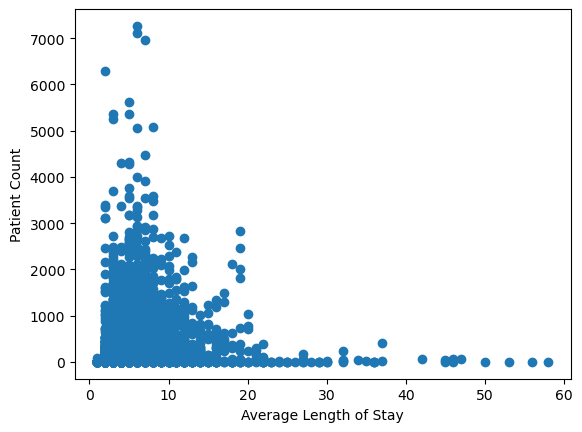

In [57]:
# Performing statistical analysis on the Length of Stay for Private and Government Insurance

# Linear regression on 
x_values = govt_ins['Average Length of Stay']
y_values = govt_ins['APR MDC Count']

# Create Plot
plt.scatter(x_values,y_values)

# Label plot and annotate the line equation
plt.xlabel('Average Length of Stay')
plt.ylabel('Patient Count')

# Show plot
plt.show()

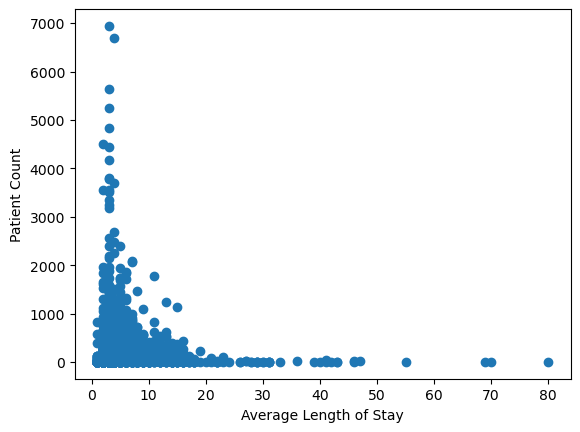

In [56]:
# Performing statistical analysis on the Length of Stay for Private and Government Insurance

# Linear regression on 
x_values = pvt_ins['Average Length of Stay']
y_values = pvt_ins['APR MDC Count']

# Create Plot
plt.scatter(x_values,y_values)

# Label plot and annotate the line equation
plt.xlabel('Average Length of Stay')
plt.ylabel('Patient Count')

# Show plot
plt.show()

In [23]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [24]:
# confirm that the "autosaurus" database is in MongoDB
print(mongo.list_database_names())

['admin', 'config', 'local']


In [25]:
# assign the database to a variable name
db = mongo['nystateinpatientdischarges2022']

In [26]:
# review the collections in our new database
collection = print(db.list_collection_names())
collection

[]


In [27]:
# review a document in the customer_list collection
print(db.NY_data_2022.find_one())

None
